**READ FROM ZIP FILE**

In [1]:
# Read contents of zip file from external url

import zipfile
import io
from urllib.request import urlopen

with (zipfile.ZipFile
      (io.BytesIO
       (urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip').read())
       )
      ) as zip:
      print(zip.namelist())

['student-mat.csv', 'student-por.csv', 'student-merge.R', 'student.txt']


In [2]:
# Read contents of zip file from local directory

import zipfile

with zipfile.ZipFile('data/student.zip') as zip:
    print(zip.namelist())

['student-mat.csv', 'student-por.csv', 'student-merge.R', 'student.txt']


In [3]:
# Read csv from zip file in local directory

import zipfile
import pandas as pd

with zipfile.ZipFile('data/student.zip') as zip:
    print(pd.read_csv(zip.open('student-mat.csv'), sep=';').sample())

   school sex  age address famsize Pstatus  Medu  Fedu   Mjob   Fjob  ...  \
40     GP   F   16       U     LE3       T     2     2  other  other  ...   

   famrel freetime  goout  Dalc  Walc health absences G1  G2  G3  
40      3        3      3     1     2      3       25  7  10  11  

[1 rows x 33 columns]


**OPTIMIZE READ/WRITE TIMES AND STORAGE SPACE OF A DATAFRAME**

In [4]:
# Loading data using pyarrow engine instead of numpy to optimize memory usage

import pandas as pd

df = pd.read_csv(
    'data/student-mat.csv', 
    dtype_backend='pyarrow',
    engine='pyarrow'    #this applies only when loading csv not xlsx
    )

In [6]:
# Further reduce memory usage of a dataframe by shrinking integer datatypes

print('Memory BEFORE shrinking integers',
      (df
       .memory_usage(deep=True)
       .sum()
       )
      )

print(df
      .dtypes
      .value_counts()
      )

def shrink_ints(df_):
    mapping = {}
    for col in df_.select_dtypes('number').columns:
        max_ = df_[col].max()
        min_ = df_[col].min()
        if min_ >= -128 and max_ <= 127:
            mapping[col] = 'int8[pyarrow]'
        elif min_ >= -32768 and max_ <= 32767:
            mapping[col] = 'int16[pyarrow]'
        elif min_ >= -2147483648 and max_ <= 2147483647:
            mapping[col] = 'int32[pyarrow]'
        
    return (df
            .astype(mapping)
    )

df = (df
      .pipe(shrink_ints)
      )

print('\n')
print(df
      .dtypes
      .value_counts()
      )

print('Memory AFTER shrinking integers',
      (df
       .memory_usage(deep=True)
       .sum()
       )
      )

Memory BEFORE shrinking integers 55263
string[pyarrow]    17
int8[pyarrow]      16
Name: count, dtype: int64


string[pyarrow]    17
int8[pyarrow]      16
Name: count, dtype: int64
Memory AFTER shrinking integers 55263


In [7]:
# Reduce memory usage even further by converting STRING datatypes to CATEGORY

print(df
      .select_dtypes('string')
      .nunique()
      )

print('Memory BEFORE shrinking integers',
      (df
       .memory_usage(deep=True)
       .sum()
       )
      )

df = (df
      .assign(**df.select_dtypes('string').astype('category'))
      )

print(df
      .dtypes
      .value_counts()
      )

print('Memory AFTER shrinking integers',
      (df
       .memory_usage(deep=True)
       .sum()
       )
      )

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64
Memory BEFORE shrinking integers 55263
int8[pyarrow]    16
category          8
category          2
category          1
category          1
category          1
category          1
category          1
category          1
category          1
Name: count, dtype: int64
Memory AFTER shrinking integers 16344


In [8]:
# Read/Write speeds can be optimized by using feather file type instead of csv/xlsx

(df
 .assign(**df
         .select_dtypes('string')
         .astype('category')
         )
 .to_feather('data/student-mat.fth')
)


df_f = pd.read_feather('data/student-mat.fth', dtype_backend='pyarrow')

**FIND FUNCTION HELP IN JUPYTER NOTEBOOKS**

In [8]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]',
    *,
    sep: 'str | None | lib.NoDefault' = <no_default>,
    delimiter: 'str | None | lib.NoDefault' = None,
    header: "int | Sequence[int] | None | Literal['infer']" = 'infer',
    names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>,
    index_col: 'IndexLabel | Literal[False] | None' = None,
    usecols: 'list[HashableT] | Callable[[Hashable], bool] | None' = None,
    dtype: 'DtypeArg | None' = None,
    engine: 'CSVEngine | None' = None,
    converters: 'Mapping[Hashable, Callable] | None' = None,
    true_values: 'list | None' = None,
    false_values: 'list | None' = None,
    skipinitialspace: 'bool' = False,
    skiprows: 'list[int] | int | Callable[[Hashable], bool] | None' = None,
    skipfooter: 'int' = 0,
    nrows: 'int | None' = None,
    na_values: 'Sequence[str] | Mapping[str, Sequence[str]] | None' = None,
    keep_default_na: 'bool' = True,
    n

**EXPLORATORY DATA ANALYSIS**

In [9]:
# Summary stats
print(df.describe(), '\n')
print(df.isna().any().sum(), '\n')
print(df.quantile([.75, .25], numeric_only=True))

              age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     3.944304    3.235443    3.108861    1.481013    2.291139    3.554430   
std      0.896659    0.9988

**CORRELATIONS**
* _Use chaining for better readability_
* _Use vmin and vmax and diverging cmap to ensure high correlations are colored distinctly_
* _Try both Pearson and Spearman coefficients_

<div class="alert alert-block alert-info">
Use Pearson coefficient when you want to measure a linear relationship between normally distributed continuous data.<br>
Use Spearman coefficient when you want to measure a monotonic relationship, especially when your data is ordinal or not normally distributed.
</div>

Markdown cheatsheet (https://www.kaggle.com/code/cuecacuela/the-ultimate-markdown-cheat-sheet)

In [10]:
(df
 .corr(numeric_only=True, method='spearman')
 .style
 .background_gradient(vmin=-1, vmax=1, cmap='RdBu')
 .format('{:,.2f}')
)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.00,-0.16,-0.15,0.11,0.03,0.24,0.03,0.00,0.14,0.10,0.13,-0.08,0.15,-0.06,-0.17,-0.17
Medu,-0.16,1.00,0.63,-0.15,0.06,-0.24,0.01,0.03,0.06,0.02,-0.04,-0.04,0.10,0.21,0.24,0.23
Fedu,-0.15,0.63,1.00,-0.15,0.02,-0.24,0.01,-0.02,0.05,0.00,-0.01,0.02,0.00,0.19,0.19,0.17
traveltime,0.11,-0.15,-0.15,1.00,-0.11,0.08,-0.04,-0.02,-0.00,0.07,0.06,-0.02,-0.03,-0.09,-0.12,-0.12
studytime,0.03,0.06,0.02,-0.11,1.00,-0.16,0.06,-0.13,-0.07,-0.22,-0.26,-0.09,-0.05,0.16,0.13,0.11
failures,0.24,-0.24,-0.24,0.08,-0.16,1.00,-0.05,0.09,0.11,0.19,0.13,0.08,0.10,-0.35,-0.36,-0.36
famrel,0.03,0.01,0.01,-0.04,0.06,-0.05,1.00,0.14,0.06,-0.11,-0.12,0.09,-0.09,0.03,0.01,0.05
freetime,0.00,0.03,-0.02,-0.02,-0.13,0.09,0.14,1.00,0.29,0.19,0.13,0.09,0.01,0.01,-0.02,-0.00
goout,0.14,0.06,0.05,-0.00,-0.07,0.11,0.06,0.29,1.00,0.26,0.39,-0.02,0.13,-0.15,-0.16,-0.17
Dalc,0.10,0.02,0.00,0.07,-0.22,0.19,-0.11,0.19,0.26,1.00,0.64,0.10,0.13,-0.11,-0.11,-0.12


**EXPLORE CATEGORICAL COLUMNS**

In [11]:
df.select_dtypes('category').columns

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [12]:
# Use crosstabs to analyze 2 categorical columns
(pd
 .crosstab(df.school, df.sex, normalize='index')
 .style
 .format('{:,.0%}')
)

sex,F,M
school,,
GP,52%,48%
MS,54%,46%


In [13]:
# Use value_counts() to analyze one categorical column at a time
for col in df.select_dtypes('category'):
    print(df[col]
          .value_counts(normalize=True)
          .rename(f'Normalized ratio of {col}')
          .mul(100)
          .round(0)
          )
    

school
GP    88.0
MS    12.0
Name: Normalized ratio of school, dtype: float64
sex
F    53.0
M    47.0
Name: Normalized ratio of sex, dtype: float64
address
U    78.0
R    22.0
Name: Normalized ratio of address, dtype: float64
famsize
GT3    71.0
LE3    29.0
Name: Normalized ratio of famsize, dtype: float64
Pstatus
T    90.0
A    10.0
Name: Normalized ratio of Pstatus, dtype: float64
Mjob
other       36.0
services    26.0
at_home     15.0
teacher     15.0
health       9.0
Name: Normalized ratio of Mjob, dtype: float64
Fjob
other       55.0
services    28.0
teacher      7.0
at_home      5.0
health       5.0
Name: Normalized ratio of Fjob, dtype: float64
reason
course        37.0
home          28.0
reputation    27.0
other          9.0
Name: Normalized ratio of reason, dtype: float64
guardian
mother    69.0
father    23.0
other      8.0
Name: Normalized ratio of guardian, dtype: float64
schoolsup
no     87.0
yes    13.0
Name: Normalized ratio of schoolsup, dtype: float64
famsup
yes    61.

<Axes: xlabel='health'>

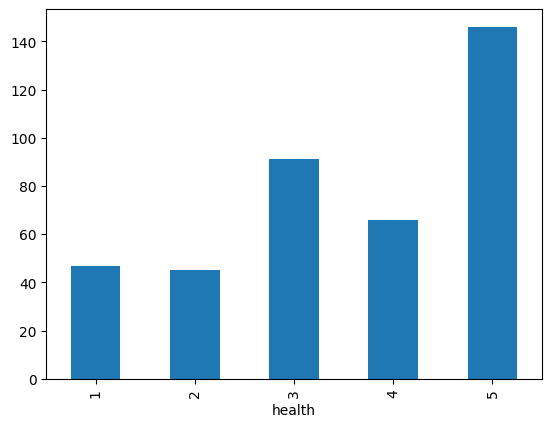

In [14]:
# Plot the value counts to read the distribution better

(df
 .health
 .value_counts()
 .sort_index(ascending=True)
 .plot.bar()
 )

**EXPLORE NUMERICAL COLUMNS**

<Axes: >

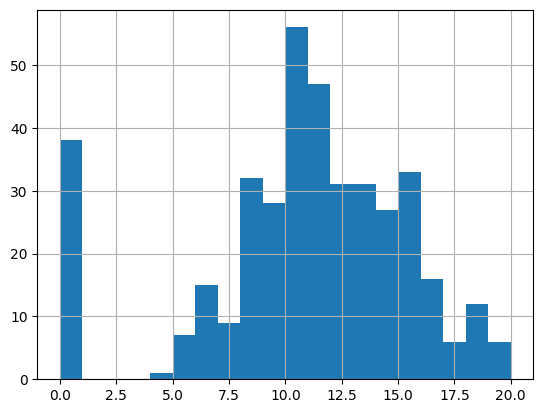

In [15]:
# Explore a single numerical column with a histogram
# Look for outliers and non-normal distribution

(df
 .G3
 .hist(bins=20)
 )

<Axes: xlabel='Medu', ylabel='G3'>

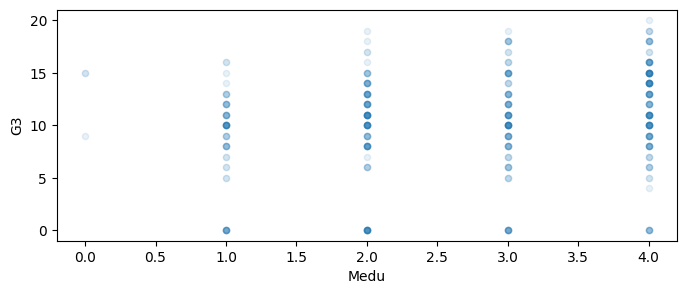

In [16]:
# Use scatter plot or swarm plot or box plot to visualize one numerical and one categorical column  
# Use scatter plot to visualize 2 numerical columns
# Look for correlations (linear as well as non-linear) high-density regions, outliers and medians  

(df
 .plot.scatter(x='Medu', y='G3', figsize=(8,3), alpha=0.1)
)

/home/codespace/.local/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Medu', ylabel='G3'>

/home/codespace/.local/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


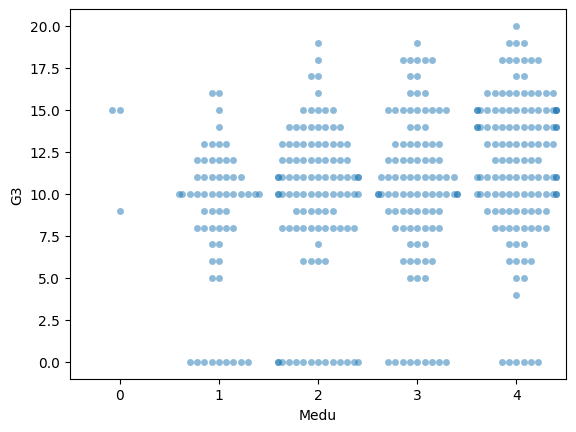

In [17]:
import seaborn as sns
sns.swarmplot(data=df, x='Medu', y='G3', alpha=0.5)

<Axes: xlabel='Medu', ylabel='G3'>

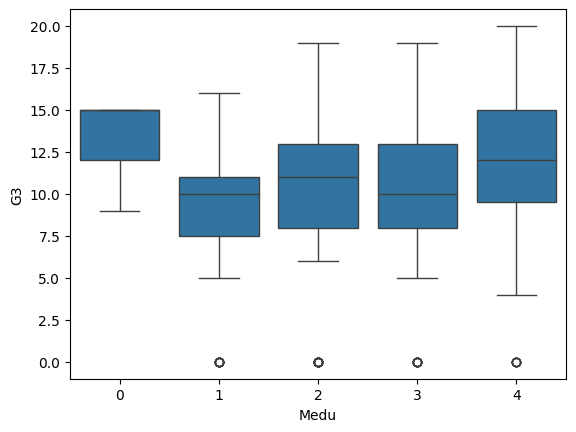

In [18]:
sns.boxplot(data=df, x='Medu', y='G3')

In [9]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [12]:
df.dtypes

school             category
sex                category
age           int8[pyarrow]
address            category
famsize            category
Pstatus            category
Medu          int8[pyarrow]
Fedu          int8[pyarrow]
Mjob               category
Fjob               category
reason             category
guardian           category
traveltime    int8[pyarrow]
studytime     int8[pyarrow]
failures      int8[pyarrow]
schoolsup          category
famsup             category
paid               category
activities         category
nursery            category
higher             category
internet           category
romantic           category
famrel        int8[pyarrow]
freetime      int8[pyarrow]
goout         int8[pyarrow]
Dalc          int8[pyarrow]
Walc          int8[pyarrow]
health        int8[pyarrow]
absences      int8[pyarrow]
G1            int8[pyarrow]
G2            int8[pyarrow]
G3            int8[pyarrow]
dtype: object

In [30]:
dt = {'name':'Sahil', 'age':'Thirty Six'}

def low(name,age='Unknown'):
    print(f'{name} is {age}')

low(**dt)

Sahil is Thirty Six


**FILTER A DATAFRAME BY USING _.query_**

In [19]:
sales_xl = pd.read_excel('data/Online Retail.xlsx')
(sales_xl
 .assign(**sales_xl.select_dtypes('object').astype('string'))
 .to_feather('data/Online Retail.fth')
)

In [20]:
sales_xl.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [21]:
import pandas as pd
sales = pd.read_feather('data/Online Retail.fth')

(sales
 .query('Quantity > 0')
 .sample()
 .T
 )

,5582
InvoiceNo,536865
StockCode,21733
Description,RED HANGING HEART T-LIGHT HOLDER
Quantity,3
InvoiceDate,2010-12-03 11:28:00
UnitPrice,5.91
CustomerID,NaN
Country,United Kingdom


**AGGREGATE DATA** 
<br>
_Use Assign, Groupby, Rename and Plot within the same code_

<Axes: title={'center': 'Sales By Year'}, xlabel='Year'>

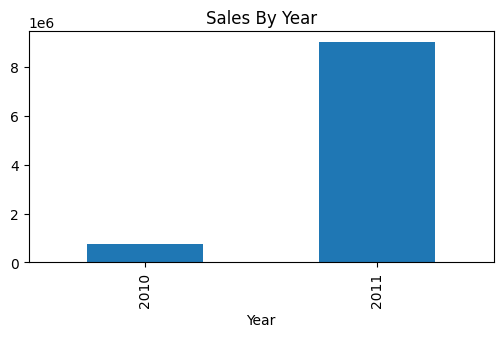

In [22]:
(sales
 .assign(Sales = sales.UnitPrice * sales.Quantity,
         Year=sales.InvoiceDate.dt.year
         )
 .groupby('Year')
 .agg(AggSales=('Sales','sum'),
      AggQty=('Quantity', 'sum'))
 .AggSales
 .plot.bar(title='Sales By Year', figsize=(6,3))
 )


<Axes: title={'center': 'Top Countries by Sales'}, ylabel='Country'>

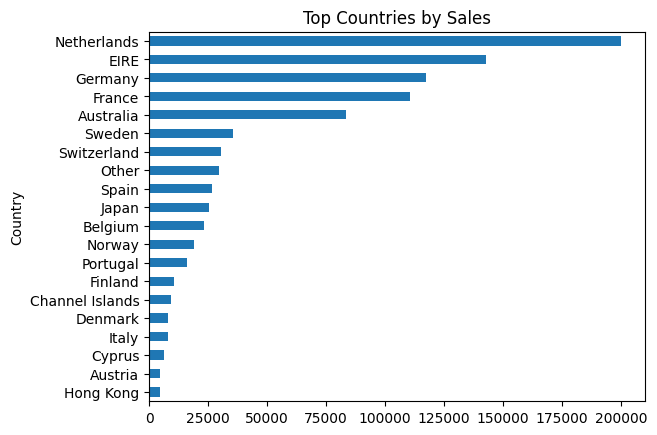

In [23]:
# Top 10 Countries by Sales (exclusing UK) and group All Others
# This uses WHERE method

n=10

def limit_n(df, col, n=20, other='Other'):
    '''
    returns names of top n countries
    '''
    top_n = (
            df
            .assign(Sales = df.UnitPrice * df.Quantity)
            .groupby('Country')
            .Sales
            .sum()
            .sort_values(ascending=False)
            .index[:n]
            )
    return top_n


(sales
 .query('Country != "United Kingdom"')
 .assign(
     Country = sales.Country.astype({'Country':'string'})
     .where(sales.Country.isin(limit_n(sales, 'Country')), 'Other'))
 .groupby('Country')
 .Quantity
 .sum()
 .sort_values()
 .plot.barh(title='Top Countries by Sales')
 )

<Axes: xlabel='InvoiceDate'>

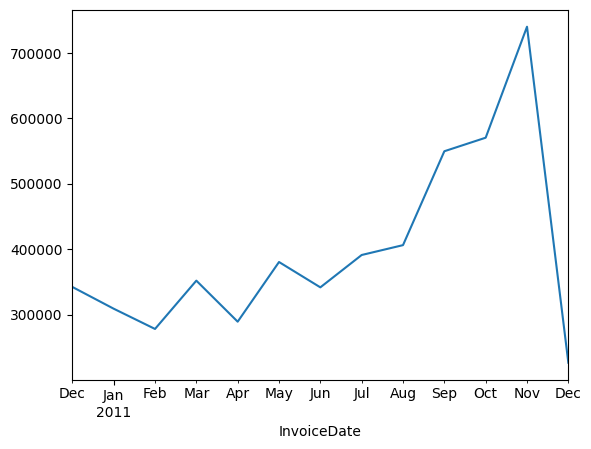

In [28]:
# Sales by Month and line plot

(sales
 .groupby(pd.Grouper(key='InvoiceDate', freq='M'))
 .Quantity
 .sum()
 .plot()
 )

In [30]:
# Sales by 3day aggregation 

(sales
 .groupby(pd.Grouper(key='InvoiceDate', freq='3D'))
 .Quantity
 .sum()
 )

InvoiceDate
2010-12-01     62667
2010-12-04     37814
2010-12-07     66167
2010-12-10     30862
2010-12-13     55950
               ...  
2011-11-26     39808
2011-11-29     83812
2011-12-02     39348
2011-12-05    112757
2011-12-08     47409
Freq: 3D, Name: Quantity, Length: 125, dtype: int64

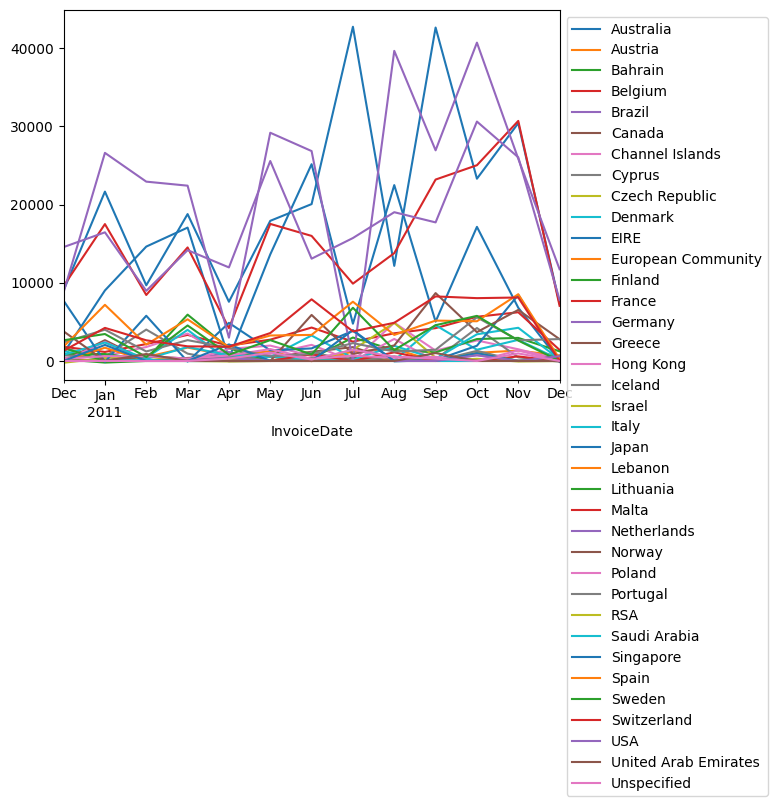

In [39]:
# Sales by Month and Country

(
 sales
 .query('Country != "United Kingdom"')
 .assign(Sales=sales.UnitPrice*sales.Quantity)
 .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])
 .Sales
 .sum()
 .unstack()
 .fillna(0)
 .plot()
 .legend(bbox_to_anchor=(1,1))
)

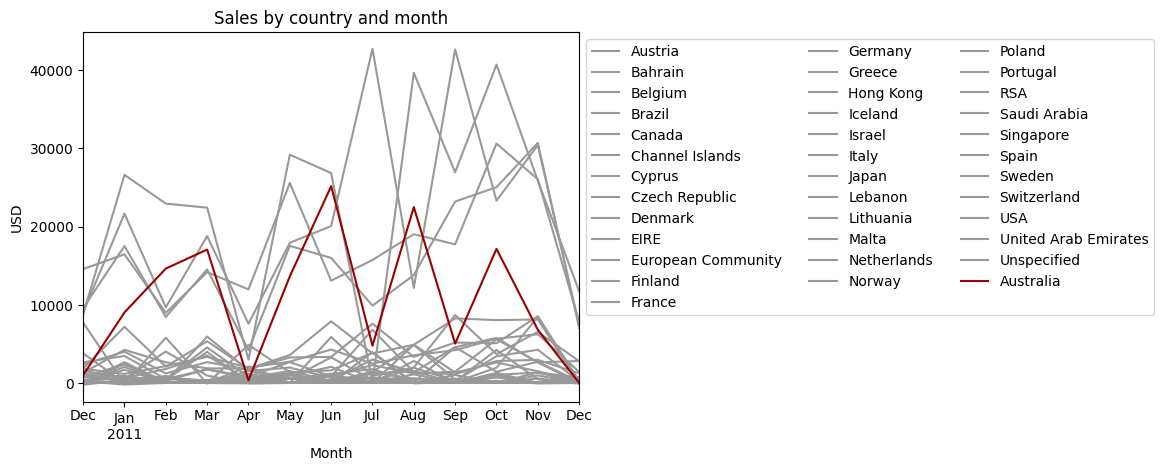

In [95]:
# Sales by Month and Country and emphasize Spain using color

colors = []
def set_colors(df, country, normal="#999999", special="#990000"):
    cols = []
    for col in df.columns:
        if col != country:
            colors.append(normal)
            cols.append(col)
    colors.append(special)
    cols.append(country)
    return df.loc[:, cols]

def plot(df):
    # (
    # df
    #  .plot(color=colors, title='Monthly Sales by Country', ylabel='USD', xlabel='Invoice Month')
    #  .legend(bbox_to_anchor=(1,1), ncols=3)
    #  .set_ylabel('USD')
    #  .set_xlabel('Months')
    # )

    # another way to plot using ax
    ax = df.plot(color=colors, title='Sales by country and month')
    ax.legend(bbox_to_anchor=(1,1), ncols=3)
    ax.set_ylabel('USD')
    ax.set_xlabel('Month')
    return df

final = (
        sales
        .query('Country != "United Kingdom"')
        .assign(Sales=sales.UnitPrice*sales.Quantity)
        .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])
        .Sales
        .sum()
        .unstack()
        .fillna(0)
        .pipe(set_colors, country='Australia')
        .pipe(plot)
        )


In [ ]:
with zipfile.ZipFile('data/student.zip') as zip:
    print(pd.read_csv(zip.open('student-mat.csv'), sep=';')

In [65]:
import glob
import zipfile

with zipfile.ZipFile('data/AirQualityUCI.zip') as zip:
    
    print(zip.namelist())

    d = pd.concat([pd.read_csv(zip.open(each), sep=';') for each in zip.namelist()[:1]], axis='index')

d

['AirQualityUCI.csv', 'AirQualityUCI.xlsx']


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for csv_file in zip.namelist()[:1]:
    d = pd.read_csv(zip.open(csv_file))
    d.shape
    print(csv_file)

AirQualityUCI.csv
